In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
inspector = inspect(engine)

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
#Perform a query to retrieve the last date in the data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date


('2017-08-23')

In [17]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [26]:
# Perform a query to retrieve the data and precipitation scores for last twelve months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()


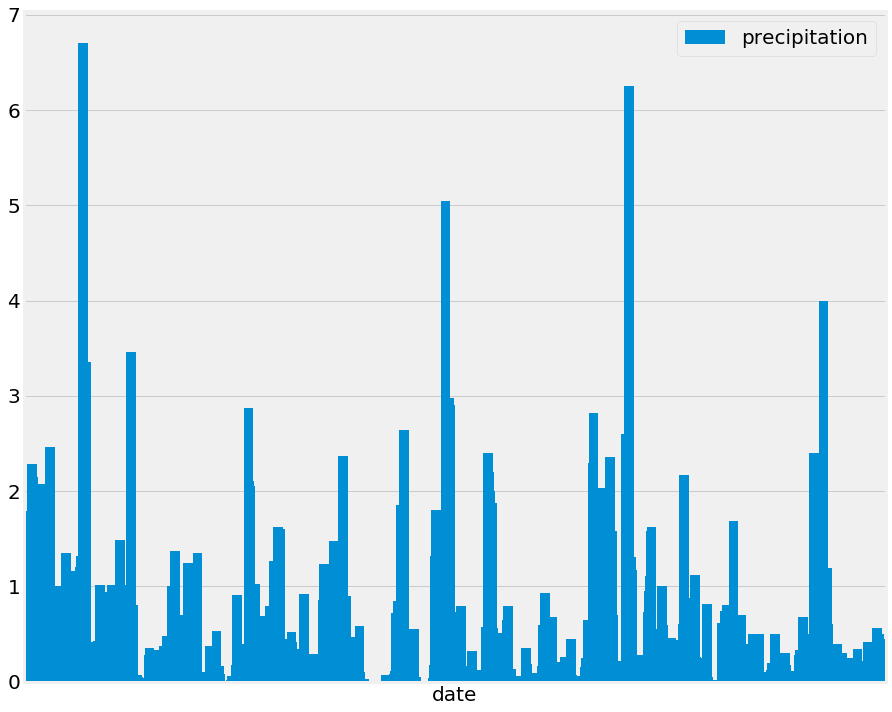

In [29]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns = ['date', 'precipitation'])

# Sort the dataframe by date
df_1 = df.sort_values(by='date',ascending=True)
df_1.set_index('date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
df_1.plot.bar(width = 25, figsize=(12.5, 10), legend=True, fontsize=20)
plt.xticks([])
plt.grid(True)
plt.xlabel("date", fontsize=20)
plt.legend(loc="best", fontsize=20)
plt.tight_layout()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(stations)

9


In [31]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [32]:
stations_no = session.query(Station.station).group_by(Station.station).count()
print(stations_no)

9


In [33]:
#station names
station_name = session.query(Station.name).group_by(Station.name).all()
station_name

[('HONOLULU OBSERVATORY 702.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('MANOA LYON ARBO 785.2, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('WAIKIKI 717.2, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US')]

In [83]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_no = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations_no

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
most_active_station = most_active[0]
most_active_station

'USC00519281'

In [38]:
#calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_most_active = session.query(*sel).filter(Measurement.station == most_active_station).all()
temp_most_active

[(54.0, 85.0, 71.66378066378067)]

In [39]:
# Choose the station with the highest number of temperature observations.
most_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
most_temp_obs_station = most_temp_obs[0]
most_temp_obs_station

'USC00519281'

In [40]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
observations = session.query(Measurement.tobs).filter(Measurement.station == most_temp_obs_station).filter(Measurement.date >= year_ago).all()

In [41]:
#convert to dataframe
df_temp = pd.DataFrame(observations, columns = ['tobs'])
df_temp.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


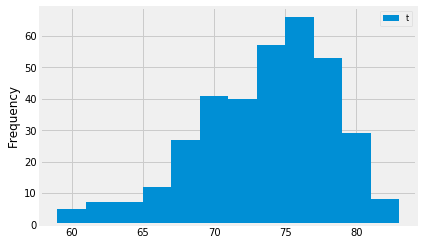

In [54]:
#Plot the results as a histogram with `bins=12`.
num_bins = 12
plt.hist(df_temp["tobs"], num_bins)
plt.ylabel("Frequency", fontsize = 12)
plt.legend("tobs", loc='upper right', fontsize = 8)
plt.show()

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-27', '2012-02-28'))

[(64.0, 70.3529411764706, 73.0)]


In [200]:
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2015-02-28', '2015-03-05'))

[(65.0, 71.5909090909091, 78.0)]


In [201]:
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [202]:
def calc_temps(start_str, end_str):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= year_ago).filter(func.strftime('%m-%d', Measurement.date) >= start_str).filter(func.strftime('%m-%d', Measurement.date)  <= end_str).all()
print(calc_temps('02-28', '03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [203]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [204]:
df_temp1 = pd.DataFrame(calc_temps('02-28', '03-05'), columns = ['TMIN','TAVG','TMAX'])
df_temp1

,TMIN,TAVG,TMAX
0,64.0,72.027778,78.0


In [205]:
df_temp_avg=df_temp1['TAVG']


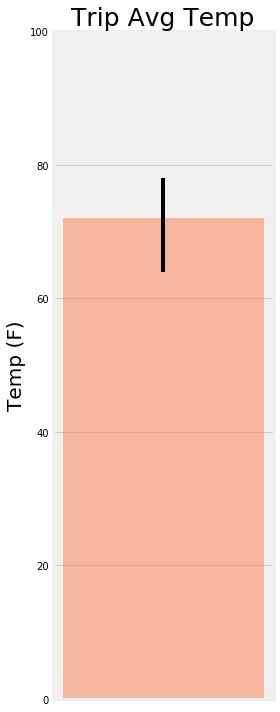

In [229]:
#df_temp1['TAVG'].plot.bar(color = 'coral',alpha = .5, figsize=(6, 10))
x_axis = np.arange(0, 1, 1)
plt.figure(figsize=(4,10))
plt.bar(x_axis, df_temp1['TAVG'], yerr=[df_temp1['TAVG']-df_temp1['TMIN'],df_temp1['TMAX']-df_temp1['TAVG']], color = 'coral', alpha = .5)
plt.xticks([])
plt.ylim(0,100)
plt.title('Trip Avg Temp', fontsize = 25)
plt.ylabel('Temp (F)', fontsize=20)
plt.tight_layout()



